# Week 5 GANs Kaggle Competition

For this project I'll be guided by the tutorial to start with the GANs and try to check where I could improve the given model architecture to get a better performance. You can find more information about this project on my GitHub [rorrostieta/monet_gan](https://github.com/rorrostieta/monet_gan).

## The Problem
This is a competition for the [I'm Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started) competition on Kaggle, where the problem for this competition is to generate images from photos which replicate or mimic [Claude Monet's](https://en.wikipedia.org/wiki/Claude_Monet) art style. This I will be following Amy Jang's tutorial [Monet CycleGAN Tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) and see what I can modify or build on to optimize the model.

## The Data
We're provided a both JPGs and TFREC files which need to be used for the training of the model. The TFREC is my choice since reading some of the [documentation](https://www.tensorflow.org/tutorials/load_data/tfrecord#tfrecords_format_details) shows how manageable it is and good to store data. To add to this since I'll be using tensors enabling the tensor processing unit (TPU) is useful in this case to achieve faster operations between tensors and it is useful with the tensorflow library.

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470


2022-10-08 22:41:40.352767: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-10-08 22:41:40.352846: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2022-10-08 22:41:40.355042: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-10-08 22:41:40.355093: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}


Number of replicas: 8
2.4.1


In [53]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [54]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


2022-10-08 22:41:55.442423: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-08 22:41:55.507285: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [55]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [56]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(15)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(15)

In [57]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

### Example Pictures
Here are a couple of examples of the pictures we're given, we have photos and monet paintings, these are 256 X 256 on a RGB format.

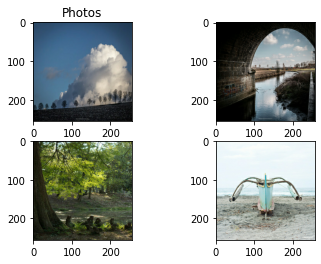

In [58]:
plt.subplot(221)
plt.title('Photos')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(222)
plt.imshow(example_photo[1] * 0.5 + 0.5)

plt.subplot(223)
plt.imshow(example_photo[2] * 0.5 + 0.5)

plt.subplot(224)
plt.imshow(example_photo[3] * 0.5 + 0.5)

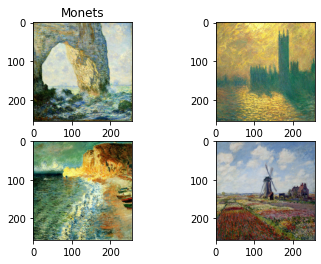

In [59]:
plt.subplot(221)
plt.title('Monets')
plt.imshow(example_monet[0] * 0.5 + 0.5)

plt.subplot(222)
plt.imshow(example_monet[1] * 0.5 + 0.5)

plt.subplot(223)
plt.imshow(example_monet[2] * 0.5 + 0.5)

plt.subplot(224)
plt.imshow(example_monet[3] * 0.5 + 0.5)

## The Model

In this part the tutorial is where I'll begin to modify the model, the tutorial employs a [UNET](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) architecture. This consists in the usage of convolutional layers to filter and resize the images accordingly in order to be able to manipulate the image information. The tutorial basically uses this architecture alongside some of the Pix2Pix model elements in order to create some functions which will pass the images through some comvolution layers to reduce the dimenions of the and be able to train the models.

One thing that this tutorial does is to considera a stride of size 2 for both the downsampling and upsampling, this would allow the images to be reduced sequentially in order for them to be interpreted and this reduction goes from 256, 128, 64, 32, 16, 8, 4, 2, 1.

Here me proposed change is looking into the downsampling and make it go faster by increasing the stide to 4, here we might loose some of the features from the images but will optimize the resource usage.

### Support Functions

In [60]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=4,
                             padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=4,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### Building the Generator and Discriminator
To build both components, due to the change we're doing to the downsampling and upsampling I'll have to consider this witin the layers. On the tutorial we had a downsampling of the generator which had the opportunity to get much more detail from the images where now we reduce the layers but reduce the downsampling. My goal is to see if this helps reduce the pixelation of the tutorial images where it barely showed a change and it just looked like a pixelated image.

In [61]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(128, 4, apply_instancenorm=False), # (bs, 64, 64, 1 28)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(128, 4), # (bs, 64, 64, 256)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=4,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

Same ting for the discriminator, to bake sure I'm doing this layer change within the discriminator I'm eliminating a layer and adjusting how it will evaluate the generated images.

In [62]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down3 = downsample(256, 4)(down1) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [63]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

## The Model
With the sugested CycleGAN structure what the we will be looking to do with the model is to input an image -> turn in into a monet -> turn it back into an image. This is how the basic CycleGAN works where the model will obtain the loss from passing it though both generators and calculate the loss from the original image versus the end result which passed first though the Monet Generator and then the Photo generator.

In [64]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Loss Functions
For tis part multiple loss functions are required since we will be evaluating multiple scenarios and we need to consider all of the loss functions. On the upper side the within the `CycleGan` where on the lower side we call all of these functions to create the cycle that will be summing up all the loss with a certain `LAMBDA` parameter which will is a hyperparameter within the class to adjust how quickly we're achieving certain loss values.

In [65]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [66]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [67]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=15
)

Epoch 1/15
20/20 [==============================] - 56s 69ms/step - monet_gen_loss: 11.4733 - photo_gen_loss: 12.1405 - monet_disc_loss: 0.6707 - photo_disc_loss: 0.6682
Epoch 2/15
 1/20 [>.............................] - ETA: 2s - monet_gen_loss: 11.0007 - photo_gen_loss: 11.5546 - monet_disc_loss: 0.6667 - photo_disc_loss: 0.6414

2022-10-08 22:42:56.760581: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 2079708, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1665268976.760516687","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 2079708, Output num: 0","grpc_status":3}


20/20 [==============================] - 1s 67ms/step - monet_gen_loss: 9.6047 - photo_gen_loss: 10.1113 - monet_disc_loss: 0.6375 - photo_disc_loss: 0.6250
Epoch 3/15
20/20 [==============================] - 1s 67ms/step - monet_gen_loss: 5.8129 - photo_gen_loss: 6.0154 - monet_disc_loss: 0.5946 - photo_disc_loss: 0.5747
Epoch 4/15
20/20 [==============================] - 1s 67ms/step - monet_gen_loss: 5.3215 - photo_gen_loss: 5.5069 - monet_disc_loss: 0.5267 - photo_disc_loss: 0.4854
Epoch 5/15
20/20 [==============================] - 1s 67ms/step - monet_gen_loss: 5.3909 - photo_gen_loss: 5.6271 - monet_disc_loss: 0.4749 - photo_disc_loss: 0.4023
Epoch 6/15
20/20 [==============================] - 1s 67ms/step - monet_gen_loss: 5.4237 - photo_gen_loss: 5.6521 - monet_disc_loss: 0.4710 - photo_disc_loss: 0.4146 0s - monet_gen_loss: 5.5717 - photo_gen_loss: 5.8634 - monet_disc_loss: 0.4570 - photo
Epoch 7/15
20/20 [==============================] - 1s 68ms/step - monet_gen_loss: 5.322

### Output / Results
From the model what we're finally expecting is that we're fiting the data from the images into the model to train the `Generator` functions which are now trained with out loss functions in order to be able to have the layers from the generator trained and be able to do the exact calculations to the images to ensure they are Monetesque.

We can now call the `Generator` and imput the imges we had within the data samples to create the images and upload for the competition.

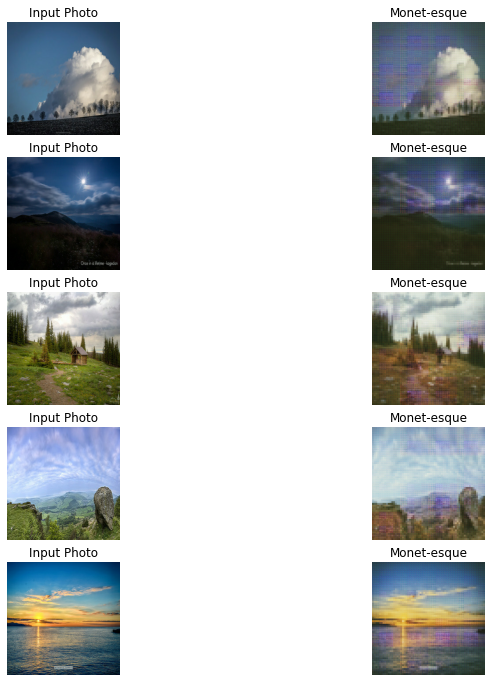

In [68]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [69]:
import PIL
! mkdir ../images

mkdir: cannot create directory ‘../images’: File exists


In [70]:
i = 1
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

2022-10-08 22:59:15.175283: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 4140686, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1665269955.175167606","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 4140686, Output num: 0","grpc_status":3}


In [71]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## Analysis
From this project we can see the importance of the how creat the generator and the discriminators to feed the model. In this case I was able to leverage the suggested CycleGan method where we cycle constantly through a model but we compute the loss which makes this unique. The objective of the loss is to measure and tune both the Generator and Discriminator.

Within my modifications of the tutorial I focused on these functions on how they affect the final output. With the default results of the tutorial I perceived the image to be quite pixelated but using the right color pallete. Moving the stride to a 4 and modifying the generator and discriminator I managed to achieve less pixelated image but lost some of the Monet pallete.

## Conclusion
GANs were a really challenging topic to understand but they can help process images un unique ways, whether its generating artificial data or extracting certain features that we might want to manipulate, some of the examples within the Tensorflow and Keras tutorials on how some GANs are used either to create artificial images show how the architectures differ between models.

For this competition managing the learning rate `LAMBDA` and the `stride` from some of the layers was the key to obtain different generators which output distinct Monet-like images. To improve this excercise we might need to use another architecture.